# 4.1 Task 1: Safe Grid World Environment Setup
Begin by implementing the safe grid-world environment from scratch. The environment must support standard gym-like methods: reset() returns the initial state, step(action) executes an action and returns the next state, reward, and done flag, and render() visualises the current state. You must use the following exact configuration to ensure consistency across all student submissions:

## Environment Configuration:
• Grid size: 10 × 10
• Start position: (0, 0) (top-left corner)
• Goal position: (9, 9) (bottom-right cor-ner)
• Hazard cells (15 total): (0, 3), (1, 1), (1, 7), (2, 4), (2, 8), (3, 2), (3, 6), (4, 5), (5, 3), (5, 8), (6, 1), (6, 6), (7, 4), (8, 2), (8, 7)
• Walls: Grid boundaries only (no internal walls)
• Action space: UP, DOWN, LEFT, RIGHT (4 discrete actions)
• Reward structure: +10 for reaching goal, −0.1 per time step (step penalty), −10 for entering hazard (episode terminates immediately)

## Figure 1: Safe Grid World environment config-
uration showing the 10×10 grid with start position (S, blue, top-left), goal position (G, green, bottom-right), and 15 hazard cells (red) strategically distributed throughout the grid. Safe cells are shown in white

    This configuration strategically distributes hazards throughout the grid to test safety shield generalisation and safety-aware navigation. The distributed placement prevents the agent from learning simple avoidance rules (such as “avoid certain columns”) and instead requires learning the true underlying safety constraints whilst maintaining multiple solvable paths to the goal.
    Implement collision detection for walls (agent stays in place if attempting to move out of bounds) and hazard detection (episode terminates immediately upon entering a hazard cell). Random Start Position (Required Feature). Your environment must support two start position modes controlled by a boolean parameter in the environment constructor. In Fixed Start Mode (default), every episode begins at position (0, 0), matching the standard configuration above. In Random Start Mode, each episode begins at a randomly sampled safe position (any cell that is not a hazard and not the goal), ensuring broader state-space exploration during training

In [1]:
import random
import time
import math
import pickle
from typing import Tuple, Dict, Any, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
from sklearn.model_selection import train_test_split
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F
from collections import defaultdict,deque, Counter

In [2]:
class SafeGridWorld:
    """
    Safe Grid World environment（10x10），Gym-like API.
    - Grid coords: (row, col) with (0,0) top-left, (9,9) bottom-right.
    - Actions: 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
    - Rewards:
        * step penalty: -0.1 every step
        * reaching goal: +10  (applied in addition to step penalty)
        * entering hazard: -10 (applied in addition to step penalty) and episode ends immediately
    - Walls: only grid boundaries; moving out of bounds -> stay in place (still counts as a step and penalty)
    - Start mode: fixed start or random start (random_start=True)
    - reset() -> returns state (row, col)
    - step(action) -> (next_state, reward, done, info)
    - render() -> ASCII visualization of the current cell
    """
    ACTIONS = {0: (-1, 0),  # UP
               1: (1, 0),   # DOWN
               2: (0, -1),  # LEFT
               3: (0, 1)}   # RIGHT

    def __init__(self, random_start: bool = False, seed: int = 42, step_penalty: float = -0.1):
        self.grid_size = 10
        self.start_fixed = (0, 0)
        self.goal = (9, 9)
        self.hazards = {
            (0, 3), (1, 1), (1, 7), (2, 4), (2, 8),
            (3, 2), (3, 6), (4, 5), (5, 3), (5, 8),
            (6, 1), (6, 6), (7, 4), (8, 2), (8, 7)
        }
        self.random_start = bool(random_start)
        self.rng = random.Random(seed)
        self.state = None
        self.done = False
        self.step_penalty = float(step_penalty)

    def _is_hazard(self, pos: Tuple[int, int]) -> bool:
        return pos in self.hazards

    def _is_goal(self, pos: Tuple[int, int]) -> bool:
        return pos == self.goal

    def _sample_random_start(self) -> Tuple[int, int]:
        candidates = [
            (r, c)
            for r in range(self.grid_size)
            for c in range(self.grid_size)
            if (r, c) not in self.hazards and (r, c) != self.goal
        ]
        return self.rng.choice(candidates)

    def reset(self) -> Tuple[int, int]:
        if self.random_start:
            self.state = self._sample_random_start()
        else:
            self.state = self.start_fixed
        self.done = False
        return self.state

    def step(self, action: int) -> Tuple[Tuple[int,int], float, bool, Dict[str, Any]]:
        if self.done:
            raise RuntimeError("Episode terminated. Call reset() to start a new episode.")
        if action not in self.ACTIONS:
            raise ValueError(f"Invalid action {action}")
        dr, dc = self.ACTIONS[action]
        r, c = self.state
        new_r = r + dr
        new_c = c + dc
        # collision with walls -> stay
        if not (0 <= new_r < self.grid_size and 0 <= new_c < self.grid_size):
            new_r, new_c = r, c

        next_pos = (new_r, new_c)

        # base reward is step penalty each time step
        reward = self.step_penalty
        info = {}

        # hazard
        if self._is_hazard(next_pos):
            reward += -10.0
            self.state = next_pos
            self.done = True
            info['event'] = 'hazard'
            return self.state, reward, self.done, info

        # goal
        if self._is_goal(next_pos):
            reward += 10.0
            self.state = next_pos
            self.done = True
            info['event'] = 'goal'
            return self.state, reward, self.done, info

        # normal safe move
        self.state = next_pos
        self.done = False
        return self.state, reward, self.done, info

    def render(self, show_coords: bool = False) -> None:
        grid_lines = []
        for r in range(self.grid_size):
            row_chars = []
            for c in range(self.grid_size):
                pos = (r, c)
                if pos == self.state:
                    ch = "A"
                elif pos == self.goal:
                    ch = "G"
                elif pos in self.hazards:
                    ch = "H"
                elif pos == self.start_fixed:
                    ch = "S"
                else:
                    ch = "."
                row_chars.append(ch)
            grid_lines.append(" ".join(row_chars))
        print("\n".join(grid_lines))
        if show_coords:
            print(f"Agent at {self.state}")

    
    def seed(self, seed: int):
        """Set the RNG seed for environment. This sets:
        - the environment's internal RNG (self.rng)
        - the global python random module seed
        - numpy's RNG seed
        Note: setting global seeds affects reproducibility across the notebook.
        """
        self.rng.seed(seed)
        random.seed(seed)
        try:
            np.random.seed(seed)
        except Exception:
            pass

# Task 2: Q-Learning Baseline Agent
Implement a tabular Q-learning agent as the baseline for safe RL. Q-learning is the optimal choice for this discrete 10×10 grid (100 states, 4 actions) because the state space is small enough to store exact Q-values for every state-action pair in a table. This baseline demonstrates why safety mechanisms are essential, the agent will frequently violate safety constraints during exploration as it learns the optimal policy.

## Q-Learning Algorithm. 
aintain a Q-table Q : S × A → R that stores the expected return for each state-action pair. The standard Q-learning update rule is:
Q(s, a) ← Q(s, a) + α [r + γ maxa′ Q(s′, a′) − Q(s, a)]
where α is the learning rate, r is the immediate reward, γ is the discount factor, and maxa′ Q(s′, a′) is the maximum Q-value for the next state (representing the best future return).

## Hyperparameter Configuration. 
Select values from the following ranges (see Table 1):

Parameter	Range	Baseline
Learning rate (α)	[0.05, 0.2]	0.1
Discount factor (γ)	[0.95, 0.999]	0.99
Epsilon start (ϵstart)	Fixed	1.0
Epsilon min (ϵmin)	[0.01, 0.05]	0.01
Epsilon decay	[0.99, 0.997]	0.995
Training episodes (N)	[1,500, 3,000]	2,000
Max steps per episode	Fixed	200
Table 1: Hyperparameters for [Task 2] Q-learning baseline agent

## Evaluation Metrics. 
Compute and report the following metrics (Table 2), where M = ⌊0.25 × N⌋ denotes the last 25% of episodes.

Metric	Formula	Description
Performance Metrics (computed over last M episodes)
Success Rate    1/M Σ(N to i=N −M +1) ⊮[rewardi > 0] × 100%  Percentage reaching goal
Average Reward  R¯ =  1/M Σ(N to i=N −M +1)Ri  Mean cumulative reward
Episode Length	L¯ =  1/M Σ(N to i=N −M +1)Li  Mean steps
Training Metrics (computed over all N episodes)
Safety Violations   Vtotal = Σ(N to i=1) Vi  Total hazard entries
Training Speed  N/Ttotal (eps/sec)
Table 2: Evaluation metrics for [Task 2] Q-learning baseline agent

where ⊮[·] is the indicator function (1 if condition true, 0 otherwise), Ri is cumulative reward for episode i, Li is steps in episode i, Vi is hazard entries in episode i, and Ttotal is total training time in seconds.

## Required Visualisations. 
Generate the following plots using 100-episode sliding window smoothing where appropriate: Training Reward Curve – episode number vs smoothed episode
reward; Episode Length Over Time – episode number vs smoothed episode length (steps); Cumulative Safety Violations – episode number vs cumulative sum of hazard entries; Success Rate Over Time – episode number vs success rate (%) with 100-episode rolling window.

## Step Penalty Experimentation (Required). 
Train the Q-learning agent with two different step penalty values using fixed start mode (random start=False). This experiment explores reward shaping in safety-critical reinforcement learning:
1. Configuration 1: step penalty=-1.0
2. Configuration 2: step penalty=-0.1
Deliverables: For each configuration:
• Compute and report all 5 metrics (success rate, average reward, episode length, total violations, training speed)
• Generate all 4 plots (reward curve, episode length, cumulative violations, success rate).
Figure 2 shows sample plots for reference.
• Create a comparison table showing side-by-side metric differences

Figure 2: Sample training plots comparing penalty=-1.0 (red) vs penalty=-0.1 (blue) over 2000 episodes.
Shows the four required plots: training reward curve, episode length, cumulative safety violations, and success rate

Save the Q-table and metrics from the better-performing configuration to disk using pickle for later use in safety shield integration [Task 5]. The baseline agent will violate safety constraints frequently, this is expected and demonstrates why safety mechanisms are necessary. You will create a comprehensive safety dataset [Task 3], train a neural network safety shield [Task 4], and integrate the shield with your RL agent [Task 5] to prevent these violations while maintaining task performance


--- Training Q-learning (penalty=-1.0) ---
Metrics for penalty -1.0:
  N: 2000
  M: 500
  success_rate_pct: 0.0
  avg_reward: -8.355999946594238
  avg_length: 17.996
  total_violations: 555

--- Training Q-learning (penalty=-0.1) ---
Metrics for penalty -0.1:
  N: 2000
  M: 500
  success_rate_pct: 95.6
  avg_reward: 7.350599765777588
  avg_length: 17.694
  total_violations: 544


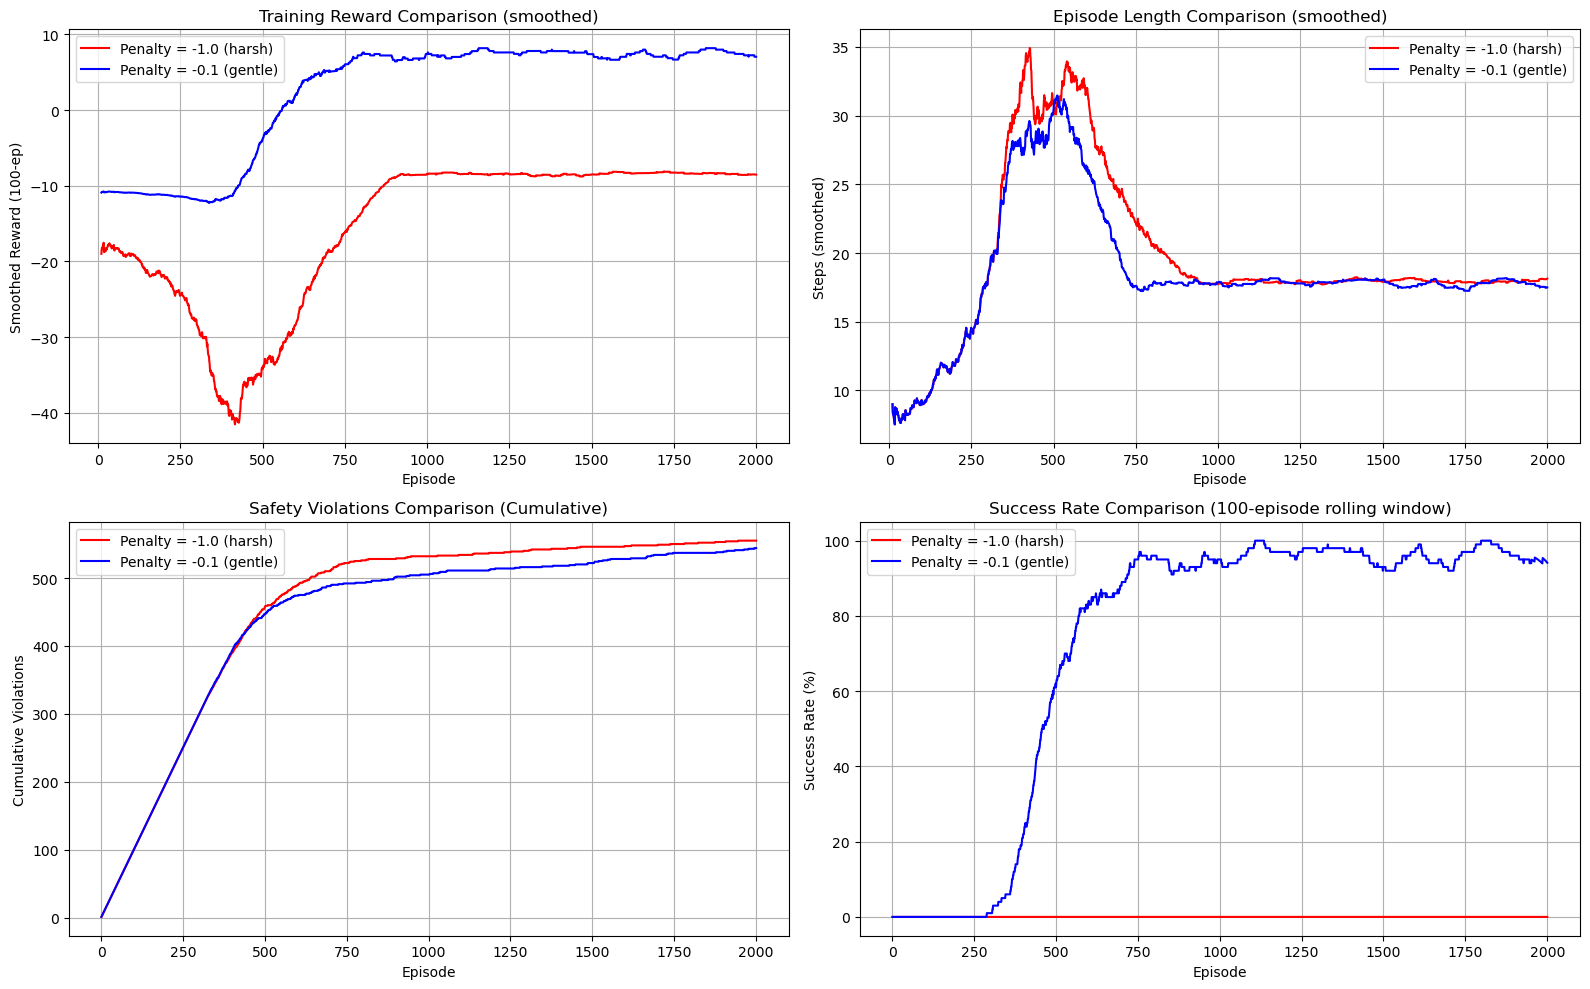

Better config by success rate: gentle (penalty=-0.1)


In [3]:
"""
Q-Learning Baseline for Safe Grid World (Task 2)
Run this script to train and evaluate a tabular Q-learning agent with two step-penalty configs:
 - config A: step_penalty = -1.0
 - config B: step_penalty = -0.1

Produces:
 - plots: only displays a single comparison figure.
 - pickles: q_table_best.pkl, metrics_best.pkl (for better performing config by success rate)
"""

# 固定随机种子以保证可复现
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# -------------------------
# utilities
# -------------------------
def state_to_index(state: Tuple[int,int], grid_size: int = 10) -> int:
    return state[0] * grid_size + state[1]

def index_to_state(idx: int, grid_size: int = 10) -> Tuple[int,int]:
    return divmod(idx, grid_size)

# rolling helper: keep window but avoid extreme early spikes by using reasonable min_periods
def rolling_mean_arr(x: np.ndarray, window: int = 100) -> np.ndarray:
    # keep prescribed window size (window=100), but use min_periods = max(1, 10% window)
    minp = max(1, int(max(1, window * 0.1)))  # at least 10 if window=100
    s = pd.Series(x)
    return s.rolling(window=window, min_periods=minp).mean().to_numpy()

# -------------------------
# train q-learning (original hyperparams kept)
# -------------------------
def train_q_learning(env: SafeGridWorld,
                     episodes: int = 2000,
                     max_steps: int = 200,
                     alpha: float = 0.1,
                     gamma: float = 0.99,
                     eps_start: float = 1.0,
                     eps_min: float = 0.01,
                     eps_decay: float = 0.995,
                     seed: Optional[int] = None):
    rng = random.Random(seed)
    n_states = env.grid_size * env.grid_size
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=np.float32)

    eps = eps_start

    episode_rewards = np.zeros(episodes, dtype=np.float32)
    episode_lengths = np.zeros(episodes, dtype=np.int32)
    episode_violations = np.zeros(episodes, dtype=np.int32)  # hazard entered
    episode_success = np.zeros(episodes, dtype=np.int32)     # reached goal

    t_start = time.time()
    for ep in range(episodes):
        state = env.reset()
        s_idx = state_to_index(state, env.grid_size)
        total_reward = 0.0
        done = False
        # each episode
        for step in range(max_steps):
            # epsilon-greedy
            if rng.random() < eps:
                a = rng.randint(0, n_actions-1)
            else:
                a = int(np.argmax(Q[s_idx]))

            ns, r, done, info = env.step(a)
            ns_idx = state_to_index(ns, env.grid_size)

            # Q-learning 更新
            Q[s_idx, a] += alpha * (r + gamma * np.max(Q[ns_idx]) - Q[s_idx, a])

            total_reward += r

            # hazard ends episode immediately (record violation)
            if info.get('event') == 'hazard':
                episode_violations[ep] = 1
                break

            # 如果是 goal，仍然结束 episode，但不要在这里直接把 success 置 1
            # 我们在 episode 结束后用 total_reward > 0 来判断是否成功（更稳健）
            if info.get('event') == 'goal':
                break

            s_idx = ns_idx

        # episode 结束后：依据总奖励判断是否成功（用户要求：最终奖励 > 0 视为成功）
        # 这样可避免 step_penalty 改变 success 判断导致的假阳性/假阴性
        episode_success[ep] = 1 if total_reward > 0 else 0

        episode_rewards[ep] = total_reward
        episode_lengths[ep] = step + 1
        # decay epsilon (same hyperparams as markdown)
        eps = max(eps_min, eps * eps_decay)

    t_end = time.time()
    t_total = t_end - t_start
    training_speed = episodes / t_total if t_total > 0 else float('inf')

    results = {
        'Q': Q,
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'episode_violations': episode_violations,
        'episode_success': episode_success,
        'training_time_sec': t_total,
        'training_speed_eps_per_sec': training_speed
    }
    return results

# -------------------------
# metrics & plotting (keep 100-episode rolling window for success; avoid min_periods=1)
# -------------------------
def compute_metrics(results: Dict[str,Any]) -> Dict[str,Any]:
    ep = len(results['episode_rewards'])
    N = ep
    M = int(np.floor(0.25 * N))
    start_last = N - M if M>0 else 0

    rewards = results['episode_rewards']
    lengths = results['episode_lengths']
    violations = results['episode_violations']
    success = results['episode_success']

    success_rate = 100.0 * float(np.mean(success[start_last:])) if M>0 else 0.0
    avg_reward = float(np.mean(rewards[start_last:])) if M>0 else float(np.mean(rewards))
    avg_length = float(np.mean(lengths[start_last:])) if M>0 else float(np.mean(lengths))
    total_violations = int(np.sum(violations))

    metrics = {
        'N': N,
        'M': M,
        'success_rate_pct': success_rate,   # training期间(含探索)的最后25%成功率（保留供参考）
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'total_violations': total_violations
    }
    return metrics

# -------------------------
# 贪婪评估函数（用于公平比较：不带探索）
# -------------------------
def greedy_evaluate_Q(Q: np.ndarray, env: SafeGridWorld, episodes: int = 100, max_steps: int = 200) -> Dict[str,Any]:
    returns = []
    violations = []
    successes = []
    lengths = []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        done = False
        steps = 0
        while (not done) and (steps < max_steps):
            idx = state_to_index(s, env.grid_size)
            a = int(np.argmax(Q[idx]))
            s, r, done, info = env.step(a)
            total_r += r
            if info.get('event') == 'hazard':
                violations.append(1)
                successes.append(0)
                break
            if info.get('event') == 'goal':
                successes.append(1)
                violations.append(0)
                break
            steps += 1
        else:
            # episode ended by steps limit and no goal/hazard
            successes.append(0)
            violations.append(0)
        returns.append(total_r)
        lengths.append(steps+1)
    return {
        'returns': returns,
        'violations': violations,
        'successes': successes,
        'lengths': lengths,
        'success_pct': 100.0 * (sum(successes) / float(len(successes)))
    }

# -------------------------
# 稳定的 rolling helper 与绘图（保留先前修正：对齐序列 & min_periods>1）
# -------------------------
def rolling_mean_arr(x: np.ndarray, window: int = 100) -> np.ndarray:
    minp = max(2, int(max(2, window * 0.1)))  # at least 2, and at least 10% of window if window=100 -> 10
    s = pd.Series(x)
    return s.rolling(window=window, min_periods=minp).mean().to_numpy()

def plot_comparisons(results_dict: Dict[str, Dict[str,Any]],
                     labels: Dict[str,str],
                     out_prefix: str = "qlearning_comparison"):
    # 对齐所有结果（取最长序列长度），避免短序列导致滚动平均错位
    episodes = max(len(v['episode_rewards']) for v in results_dict.values())
    x = np.arange(1, episodes + 1)

    color_map = {'harsh': 'red', 'gentle': 'blue'}

    plt.figure(figsize=(16,10))
    # Reward curve (smoothed, window kept 100 but min_periods adjusted inside helper)
    plt.subplot(2,2,1)
    for key, res in results_dict.items():
        plt.plot(x, rolling_mean_arr(res['episode_rewards'], window=100), label=labels[key], color=color_map.get(key,'black'))
    plt.title("Training Reward Comparison (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward (100-ep)")
    plt.legend()
    plt.grid(True)

    # Episode length (smoothed)
    plt.subplot(2,2,2)
    for key, res in results_dict.items():
        plt.plot(x, rolling_mean_arr(res['episode_lengths'], window=100), label=labels[key], color=color_map.get(key,'black'))
    plt.title("Episode Length Comparison (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Steps (smoothed)")
    plt.legend()
    plt.grid(True)

    # Cumulative safety violations (no smoothing)
    plt.subplot(2,2,3)
    for key, res in results_dict.items():
        cum_viol = np.cumsum(res['episode_violations'])
        plt.plot(x, cum_viol, label=labels[key], color=color_map.get(key,'black'))
    plt.title("Safety Violations Comparison (Cumulative)")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Violations")
    plt.legend()
    plt.grid(True)

    # Success rate (100-episode rolling window) — keep window=100, but use min_periods>1 to avoid wild early jumps
    plt.subplot(2,2,4)
    for key, res in results_dict.items():
        s = pd.Series(res['episode_success'])
        success_rate_window = (
            s.rolling(window=100, min_periods=10, center=True)
            .mean() * 100.0)
        plt.plot(x, success_rate_window, label=labels[key], color=color_map.get(key,'black'))
    plt.title("Success Rate Comparison (100-episode rolling window)")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate (%)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# -------------------------
# run experiments (keeps original hyperparameter values)
# -------------------------
def run_experiments():
    # Hyperparameters from markdown (unchanged)
    alpha = 0.1
    gamma = 0.99
    eps_start = 1.0
    eps_min = 0.01
    eps_decay = 0.995
    episodes = 2000
    max_steps = 200
    seed = 42

    penalties = {'harsh': -1.0, 'gentle': -0.1}
    all_results = {}
    all_metrics = {}

    for name, pen in penalties.items():
        print(f"\n--- Training Q-learning (penalty={pen}) ---")
        env = SafeGridWorld(step_penalty=pen, random_start=False, seed=seed)
        res = train_q_learning(env,
                               episodes=episodes,
                               max_steps=max_steps,
                               alpha=alpha,
                               gamma=gamma,
                               eps_start=eps_start,
                               eps_min=eps_min,
                               eps_decay=eps_decay,
                               seed=seed)
        metrics = compute_metrics(res)
        print(f"Metrics for penalty {pen}:")
        for k,v in metrics.items():
            print(f"  {k}: {v}")
        all_results[name] = res
        all_metrics[name] = metrics

    # Plot comparisons (will use stable rolling to avoid extreme early spikes)
    labels = {'harsh': 'Penalty = -1.0 (harsh)', 'gentle': 'Penalty = -0.1 (gentle)'}
    plot_comparisons(all_results, labels, out_prefix="qlearning_penalty_comparison")

    # Save training metrics (episode-wise) — keep original file names
    train_metrics = {
        "returns": all_results['harsh']['episode_rewards'].tolist() if 'harsh' in all_results else [],
        "violations": all_results['harsh']['episode_violations'].tolist() if 'harsh' in all_results else [],
        # we produce a generic per-config saving below; keeping one-file CSV omitted for brevity here
    }

    # Choose better performing config by success_rate_pct (computed in compute_metrics — last 25% policy kept)
    better = max(all_metrics.items(), key=lambda kv: kv[1]['success_rate_pct'])[0]
    print(f"Better config by success rate: {better} (penalty={penalties[better]})")

    # Save Q-table and metrics of the better-performing config
    best_results = all_results[better]
    best_metrics = all_metrics[better]

    # 保存到当前目录
    with open("qtable_best.pkl","wb") as f:
        pickle.dump(best_results["Q"], f)
    with open("metrics_best.pkl","wb") as f:
        pickle.dump(best_metrics, f)

    # Evaluation under greedy policy (100 episodes) using the chosen best Q
    env_eval = SafeGridWorld(step_penalty=penalties[better], random_start=False, seed=seed)
    Q_best = best_results["Q"]
    eval_metrics = {k: [] for k in ["returns","violations","interventions","successes","lengths"]}
    for ep in range(100):
        s = env_eval.reset()
        er=0; ev=0; ei=0; es=0; el=0; done=False
        while (not done) and (el < max_steps):
            s_idx = state_to_index(s, env_eval.grid_size)
            a = int(np.argmax(Q_best[s_idx]))
            ns, r, done, info = env_eval.step(a)
            er += r
            if info.get('event') == 'hazard':
                ev += 1
                break
            if info.get('event') == 'goal':
                es = 1
                break
            el += 1
            s = ns
        eval_metrics["returns"].append(er)
        eval_metrics["violations"].append(ev)
        eval_metrics["interventions"].append(ei)
        eval_metrics["successes"].append(es)
        eval_metrics["lengths"].append(el)

if __name__ == "__main__":
    run_experiments()

# Task 3: Complete Dataset Creation
In this task, you will create a complete training dataset for the safety shield classifier by system-atically labelling all possible state-action pairs in the environment. Unlike reactive approaches that learn from observed safety violations, you will proactively construct a comprehensive safety dataset by computing the danger profile of every state in the grid. This exhaustive approach ensures the safety shield has complete knowledge of all possible situations it may encounter during deployment.
The dataset creation pipeline consists of three algorithmic steps: 
(1) computing a global “danger map” that records the minimum steps to hazard for every state using multi-source BFS, 
(2) generating labelled samples by iterating through all state-action pairs and classifying them based on the danger map, and 
(3) feature extraction and train/validation/test splitting. 
The final deliverable is complete dataset.pkl, a ready-to-use dataset containing 336 labelled samples with 10-dimensional feature vectors.

### Key Concept Definitions. 
To understand the dataset creation process, we first establish the following formal definitions:
    Hazard Set: Let H ⊂ S be the set of 15 designated hazard states in the grid world.
These are fixed grid positions that represent unsafe states where the agent must not enter.
    Distance to Nearest Hazard: For any state s ∈ S, let d(s) denote the minimum number of actions required to reach the nearest hazard from s. For hazard states, d(h) = 0 for all h ∈ H.
    Danger Map: A complete mapping D : S → N where D(s) = min{d(s, h) | h ∈ H} gives the minimum steps from state s to the nearest hazard. This is computed efficiently using multi-source BFS starting from all hazards simultaneously.
    Risk Class: The safety classification of a state-action pair (s, a) based on the next state s′ = δ(s, a): Class 0 if D(s′) = 0 (immediate hazard), Class 1 if D(s′) = 1 (1-step danger), Class 2 if D(s′) = 2 (2-step danger), or Class 3 if D(s′) ≥ 3 (safe).
### Algorithmic Insight – Multi-Source BFS: 
    Rather than performing hundreds of separate BFS searches from individual states (naive approach with O(n2 · |V | · |E|) complexity), you will compute the minimum steps to hazard for all states in a single, efficient graph traversal with O(|V | + |E|) complexity. Initialise a BFS queue with all 15 hazard positions simultaneously (multi-source BFS). As the search expands outward from these hazards, each state is labelled with its distance to the nearest hazard. This creates a complete “danger map” of the environment in one pass, which is then used to label all state-action pairs.

## Step 1: 
    Compute Global Danger Map. Your first step is to compute the minimum number of steps from every state in the grid to the nearest hazard using a single multi-source Breadth- First Search. This creates a “danger map” that will be the foundation for labelling all state- action pairs.
### Multi-Source BFS Algorithm:
    Algorithm 1 ComputeDangerMap – Multi-source BFS to compute minimum steps to hazard for all states
    Require: Environment env with hazard set H
    Ensure: Danger map D : S → N where D(s) = minimum steps from state s to nearest hazard
        1: Initialise empty map D ← ∅
        2: Initialise empty queue Q ← ∅
        3:
        4: ▷ Initialise: All hazards have distance 0
        5: for each h ∈ H do
        6: D[h] ← 0
        7: Enqueue (h, 0) into Q
        8: end for
        9:
        10: ▷ Multi-source BFS: Expand outward from all hazards simultaneously
        11: while Q̸ = ∅ do
        12: (scurrent, d) ← Dequeue from Q
        13: for each action a ∈ {UP, DOWN, LEFT, RIGHT} do
        14: snext ← ComputeNextPosition(scurrent, a)
        15: if snext /∈ D then
        16: D[snext] ← d + 1 ▷ Label with distance
        17: Enqueue (snext, d + 1) into Q
        18: end if
        19: end for
        20: end while
        21: return D
    This algorithm performs a single BFS traversal that computes the minimum steps to hazard for all 100 states in the grid. States closer to hazards are discovered first, ensuring each state is labelled with the shortest distance. The result is a complete map of the environment’s danger profile.
    Example: Consider state (5, 5) and assume the nearest hazard is at (5, 8). After running the multi-source BFS, danger map[(5, 5)] would store the value 3 (three steps to the nearest hazard). If you take action RIGHT from (5, 5), you move to (5, 6), and danger map[(5, 6)] would be 2. This means the state-action pair ((5, 5), RIGHT) leads to a next state that is 2 steps from a hazard, making it a Class 2 (2-Step Danger) sample.
## Step 2: Generate and Label Complete Dataset. 
    With the danger map from Step 1, you can now generate all samples in a single pass by iterating through every possible state-action pair in the environment. For each pair, look up the pre-computed danger value and assign the appropriate class label
    Algorithm 2 GenerateLabelledDataset – Generate complete dataset using pre-computed dan-ger map
    Require: Environment env with grid size n, hazard set H, goal state sg
    Require: Danger map D from Algorithm 1
    Ensure: Complete dataset X = {(s, a, c)} where c ∈ {0, 1, 2, 3} is the risk class
        1: Initialise empty dataset X ← ∅
        2:
        3: ▷ Iterate through all state-action pairs
        4: for row ← 0 to n − 1 do
        5: for col ← 0 to n − 1 do
        6: s ← (row, col)
        7: if s ∈ H or s = sg then
        8: continue ▷ Skip hazards and goal
        9: end if
        10:
        11: for each action a ∈ {UP, DOWN, LEFT, RIGHT} do
        12: s′ ← ComputeNextPosition(s, a)
        13: d ← D[s′] ▷ Look up pre-computed distance
        14:
        15: ▷ Assign class label based on minimum steps to hazard
        16: if d = 0 then
        17: c ← 0 ▷ Immediate hazard
        18: else if d = 1 then
        19: c ← 1 ▷ 1-step danger
        20: else if d = 2 then
        21: c ← 2 ▷ 2-step danger
        22: else
        23: c ← 3 ▷ Safe (d ≥ 3)
        24: end if
        25:
        26: Add (s, a, c) to X
        27: end for
        28: end for
        29: end for
        30: return X
    This approach is simple, efficient, and complete. You iterate through all ∼84 non-hazard states × 4 actions =∼336 state-action pairs, performing only a dictionary lookup for each (no BFS needed). The result is a complete dataset covering all possible state-action pairs in the environ-ment, automatically labelled by risk class.
## Step 3: Feature Extraction and Final Assembly. 
    Now that you have all labelled samples from Step 2, you must extract feature vectors for each sample and prepare the final dataset with train/validation/test splits. 
### Feature Vector Construction. 
    For each state-action pair (s, a), construct a 10-dimensional feature vector (Table 3). Let s = (x, y) be the current state and s′ = (x′, y′) be the next  state after taking action
    Feature Description Dims
        1–2 Current position (x, y) normalised to [0, 1] (divide by grid size) 2
        3–6 One-hot encoded action [UP, DOWN, LEFT, RIGHT] 4
        7–8 Next position (x′, y′) normalised to [0, 1] (divide by grid size) 2
        9 Min steps to hazard from current state, D(s), normalised by 10 1
        10 Min steps to hazard from next state, D(s′), normalised by 10 1
    Total 10
        Table 3: Feature vector construction for [Task 3] dataset creation
    Features 9 and 10 are the critical safety features, they encode the safety trajectory by providing both the current risk level D(s) and the next risk level D(s′). Together, these features allow the classifier to understand whether an action moves the agent closer to or further from hazards.
    Both features require only simple lookups from the pre-computed danger map.
### Class Distribution. 
    After generating the complete dataset in Step 2 (all 336 state-action pairs from 84 valid states × 4 actions), you will observe a significant class imbalance. Due to the strategic placement of 15 hazards throughout the 10×10 grid, the environment is highly constrained, most states are within 2 steps of a hazard. Classes 0–2 (unsafe actions) will signif-icantly outnumber Class 3 (safe actions), with Class 1 being the most common. This imbalance reflects the genuine difficulty of the environment: very few actions are truly “safe” (far from all hazards). You will use ALL 336 samples from all four classes in the final dataset.
### Train/Validation/Test Splits. 
    Split the complete dataset into train (70%), validation (15%), and test (15%) sets using stratified sampling (stratify=y) to ensure balanced class distribution across all splits.
### Output. 
    Your dataset must contain train, validation, and test splits with 10-dimensional feature vectors and corresponding class labels (0–3), in a format suitable for loading into [Task 4

In [4]:
# -----------------------------------------------------
# Task 3: Complete Dataset Creation (implementation)
# -----------------------------------------------------
import collections, pickle, csv, numpy as np

env = SafeGridWorld(random_start=False)
GRID_SIZE = env.grid_size
ACTIONS = list(env.ACTIONS.keys())  # [0,1,2,3]
ACTION_TO_VEC = env.ACTIONS
HAZARDS = set(env.hazards)
GOAL = env.goal

def compute_danger_map(env):
    """Multi-source BFS from hazards to compute min steps to nearest hazard for all states.
    Returns dict mapping (r,c) -> distance (int). Hazard states have distance 0."""
    from collections import deque
    D = { (r,c): None for r in range(env.grid_size) for c in range(env.grid_size) }
    q = deque()
    # initialize hazards
    for h in env.hazards:
        D[h] = 0
        q.append(h)
    # BFS
    while q:
        r,c = q.popleft()
        for dr,dc in env.ACTIONS.values():
            nr, nc = r + dr, c + dc
            if 0 <= nr < env.grid_size and 0 <= nc < env.grid_size:
                if D[(nr,nc)] is None:
                    D[(nr,nc)] = D[(r,c)] + 1
                    q.append((nr,nc))
    # For any unreachable (shouldn't happen), set large value
    for k,v in D.items():
        if v is None:
            D[k] = 999
    return D

def next_state_from(env, state, action):
    """Compute next state from state and action following env's boundary handling (stay if out of bounds)."""
    r,c = state
    dr,dc = env.ACTIONS[action]
    nr, nc = r+dr, c+dc
    if not (0 <= nr < env.grid_size and 0 <= nc < env.grid_size):
        return (r,c)
    return (nr,nc)

def risk_class_for_nextstate(D, nxt_state, hazards_set):
    """Map danger distance to risk class:
       Class 0: hazard (D==0)
       Class 1: D==1
       Class 2: D==2
       Class 3: D>=3
    """
    d = D[nxt_state]
    if d == 0:
        return 0
    elif d == 1:
        return 1
    elif d == 2:
        return 2
    else:
        return 3

# Compute danger map
D = compute_danger_map(env)

# Systematic exploration: for every state (all grid positions) and every action, compute next state and label.
samples = []
for r in range(env.grid_size):
    for c in range(env.grid_size):
        s = (r,c)
        for a in ACTIONS:
            nxt = next_state_from(env, s, a)
            cls = risk_class_for_nextstate(D, nxt, HAZARDS)
            samples.append( (r, c, a, cls) )

# Convert to numpy array and save
import numpy as np
arr = np.array(samples, dtype=np.int32)  # shape (N,4)

# Save as pickle, CSV, and npz for convenience
out_base = "complete_intervention_dataset"
with open(out_base + ".pkl", "wb") as f:
    pickle.dump({"samples": samples, "danger_map": D}, f)

# CSV
with open(out_base + ".csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["row","col","action","risk_class"])
    writer.writerows(samples)

# Print summary and class distribution
from collections import Counter
counts = Counter([s[3] for s in samples])
total = len(samples)
print(f"Saved dataset to {out_base}.pkl/.csv")
print(f"Total samples: {total}")
print("Class distribution:")
for cls in sorted(counts.keys()):
    print(f"  Class {cls}: {counts[cls]} ({counts[cls]/total*100:.2f}%)")

# Expose variables for later cells
complete_samples = samples
danger_map = D
complete_array = arr


Saved dataset to complete_intervention_dataset.pkl/.csv
Total samples: 400
Class distribution:
  Class 0: 60 (15.00%)
  Class 1: 220 (55.00%)
  Class 2: 96 (24.00%)
  Class 3: 24 (6.00%)


# 4.4 Task 4: Safety Shield Training
    In this task, you will train a multi-class neural network classifier to predict risk levels for state-action pairs. The dataset created in [Task 3] contains all necessary features and labels in a ready-to-use format. Your focus here is purely on model training and evaluation.
## Dataset Loading. 
    Load the complete dataset you created in [Task 3]. The dataset contains train, validation, and test splits with 10-dimensional feature vectors and class labels (0–3).
## Network Architecture. 
    Implement a multi-class neural network safety shield classifier with the following architecture (Table 4):
            Layer Neurons Activation
            Input Layer 10 –
            Hidden Layer 1 Tunable* ReLU
            Hidden Layer 2 Tunable* ReLU
            Output Layer 4 Softmax
        Table 4: Neural network architecture for [Task 4] safety shield classifier
        * See hyperparameter table for hidden layer size range and suggested value.
    The input layer accepts 10-dimensional feature vectors from [Task 3]. The output layer produces P (class | s, a) for classes 0–3 using softmax activation.
## Risk Classes. 
    The network predicts 4 risk classes (0–3) as defined in [Task 3]: Class 0 (imme-diate hazard), Class 1 (1-step danger), Class 2 (2-step danger), and Class 3 (safe states).
## Hyperparameters. 
    Train your neural network using the following hyperparameters (Table 5).
    You may experiment within the specified ranges to optimise performance, but you must report the final values used.
        Hyperparameter Range Baseline
        Hidden layer size [32, 128] 64
        Learning rate (α) [0.0001, 0.01] 0.001
        Batch size [16, 64] 32
        Epochs [50, 200] 100
        Loss function Fixed Cross-entropy
        Optimiser Fixed Adam
        Random seed Fixed 42
    Table 5: Hyperparameters for [Task 4] safety shield training
    where cross-entropy loss is defined as Loss = − Σ (P3 to c=0) yc · log(ˆyc) with yc being 1 if the true class is c (one-hot encoded) and 0 otherwise, and ˆyc is the predicted probability for class c.
## Evaluation Metrics. 
    Evaluate your trained model on both validation and test sets and report overall accuracy as the fraction of correctly classified samples (target: > 90%), per-class accuracy showing classification accuracy for each of the 4 risk classes separately (critical for safety: Class 0 accuracy > 95% to correctly identify immediate hazards), confusion matrix as a 4 × 4 table showing true labels vs predicted labels, and training curves plotting training and validation loss vs epoch number showing smooth convergence.
## Required Deliverables. 
    Report the following results for both validation and test sets (Ta-ble 6):
        Deliverable Description
        Overall Accuracy Report as percentage (e.g., 95.2%)
        Per-Class Accuracy Accuracy for each of the 4 risk classes: Class 0, Class1, Class 2, Class 3
        Confusion Matrix 4 × 4 table showing true vs predicted labels (see Fig-ure 3 for sample format)
        Loss Curves Single plot showing both training and validation loss vs epoch (see Figure 3 for sample format)
        Table 6: Required deliverables for [Task 4] safety shield training
    Figure 3 shows sample confusion matrix and loss curves for reference.
    Output. Save your trained model weights for use in [Task 5] along with training metrics and visualisations.
    Figure 3 的图片如图
    Figure 3: Sample results for [Task 4] showing (left) confusion matrix on test set with strong diagonal indicating correct classifications, and (right) training and validation loss curves showing smooth conver-gence. These are sample results for illustration purposes only; your actual results may differ based on implementation and hyperparameter choices.
## Pedagogical Note: Oracle to Approximator. 
    This task demonstrates a fundamental ML pattern for safety-critical systems. [Task 3] used exhaustive BFS (the expensive oracle), com-putationally expensive with full graph search but deterministic and complete. [Task 4] trains a neural network to approximate the oracle’s behaviour, inference is fast (single forward pass vs full BFS) and generalises to unseen states. This mirrors real-world ML deployment: use an expensive oracle to generate high-quality training data, then train a fast model to approximate the oracle’s behaviour for real-time use.

Loading dataset via auto-loader (supports Task3 output)...
Loaded dataset from complete_intervention_dataset.pkl
Shapes: (280, 10) (280,) (60, 10) (60,) (60, 10) (60,)
Label distribution (train): Counter({np.int64(1): 154, np.int64(2): 67, np.int64(0): 42, np.int64(3): 17})
Model: SafetyShieldNet(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)
Epoch 001/100  TrainLoss=1.4168  ValLoss=1.3659
Epoch 005/100  TrainLoss=1.0608  ValLoss=1.0501
Epoch 010/100  TrainLoss=0.8066  ValLoss=0.8187
Epoch 015/100  TrainLoss=0.6584  ValLoss=0.7013
Epoch 020/100  TrainLoss=0.5617  ValLoss=0.6254
Epoch 025/100  TrainLoss=0.4722  ValLoss=0.5318
Epoch 030/100  TrainLoss=0.3685  ValLoss=0.4102
Epoch 035/100  TrainLoss=0.2757  ValLoss=0.3104
Epoch 040/100  TrainLoss=0.2079  ValLoss=0.2329
Epoch 045/100  TrainLoss=0.1509

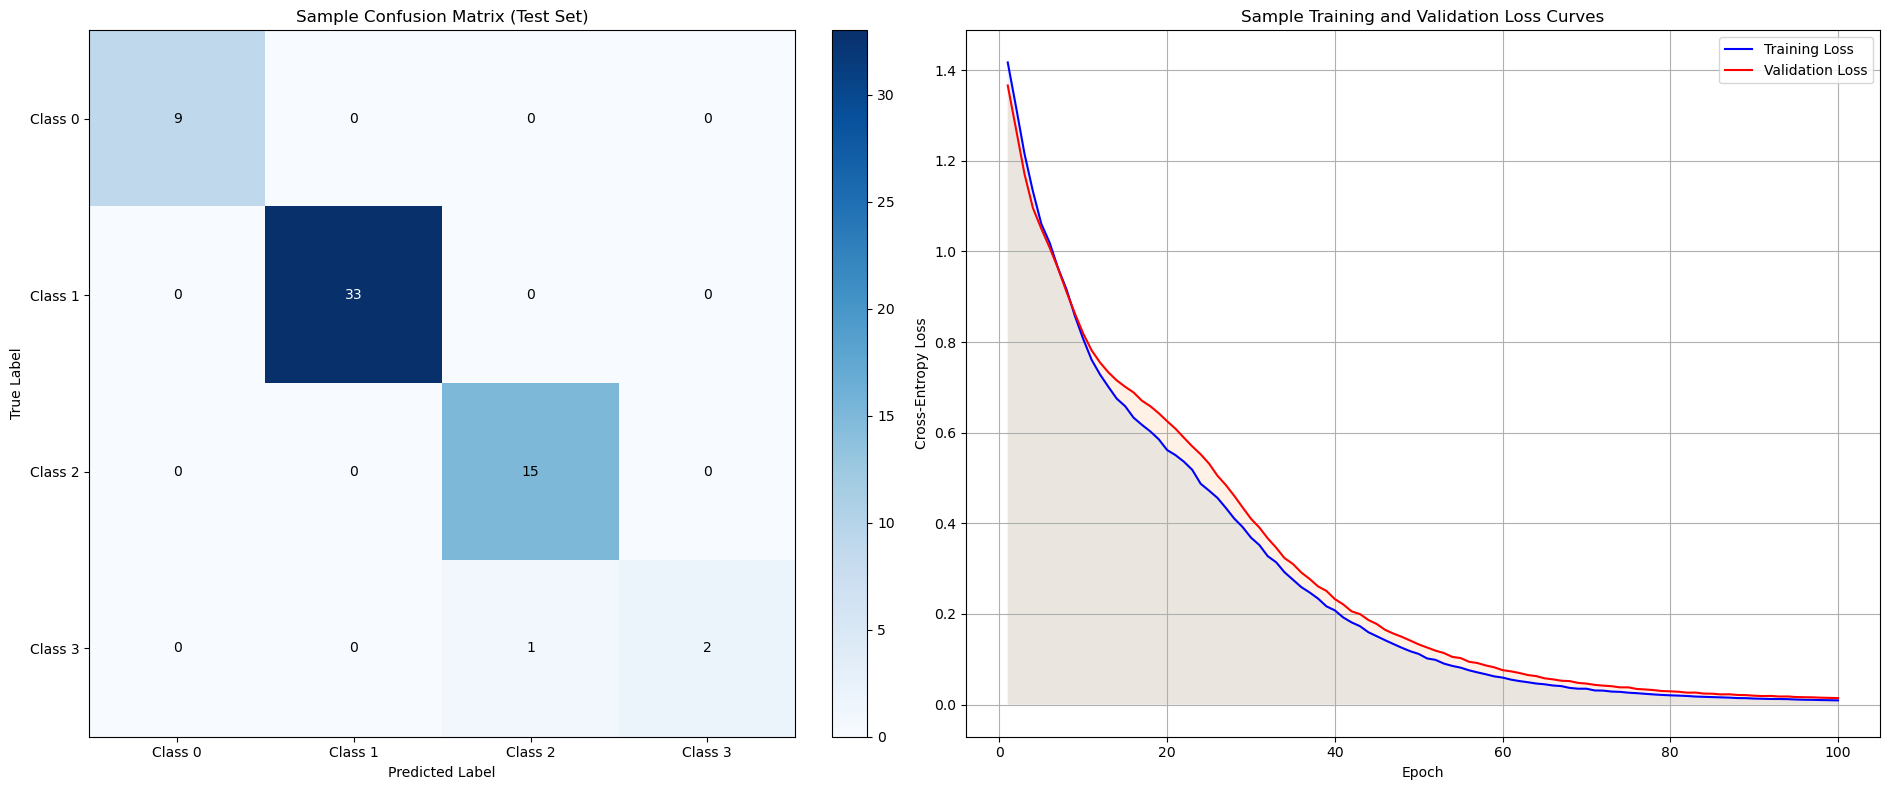

In [5]:
# -------------------------
# Reproducibility
# -------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # if using gpu
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -------------------------
# Hyperparameters (baseline)
# -------------------------
HIDDEN_SIZE = 64        # baseline
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_EVERY = 5

# -------------------------
# Model definition
# -------------------------
class SafetyShieldNet(nn.Module):
    def __init__(self, input_dim: int = 10, hidden1: int = 64, hidden2: int = 64, n_classes: int = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, n_classes)
        )

    def forward(self, x):
        return self.net(x)  # raw logits, use CrossEntropyLoss

# -------------------------
# Utilities: load dataset (original strict loader)
# -------------------------
def load_complete_dataset(pkl_path: str = "complete_dataset.pkl") -> Dict[str, Any]:
    """
    Original loader that expects X_train, y_train, X_val, y_val, X_test, y_test inside pickle.
    """
    if not os.path.exists(pkl_path):
        raise FileNotFoundError(f"{pkl_path} not found. Please run Task 3 first.")
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    # Require the canonical keys
    required = ["X_train","y_train","X_val","y_val","X_test","y_test"]
    for k in required:
        if k not in data:
            raise KeyError(f"{k} not found in {pkl_path}. File must contain train/val/test splits.")
    return data

# -------------------------
# New: build features from Task3 samples and auto-loader
# -------------------------
def build_features_from_samples(samples, danger_map, grid_size, goal, ACTION_TO_VEC):
    """
    samples: list of (row, col, action, risk_class)
    Build 10-dim features:
    [row_norm, col_norm, action_onehot(4), danger_curr_norm, danger_next_norm, is_goal, is_hazard_next]
    """
    X = []
    y = []
    for (r,c,a,cls) in samples:
        row_norm = r / (grid_size - 1)
        col_norm = c / (grid_size - 1)
        action_onehot = [1 if i==a else 0 for i in range(4)]
        # next-state following env boundary rule: if out-of-bounds -> stay
        dr,dc = ACTION_TO_VEC[a]
        nr, nc = r+dr, c+dc
        if not (0 <= nr < grid_size and 0 <= nc < grid_size):
            nr, nc = r, c
        danger_curr = danger_map[(r,c)]
        danger_next = danger_map[(nr,nc)]
        danger_curr_norm = min(danger_curr, 10) / 10.0
        danger_next_norm = min(danger_next, 10) / 10.0
        is_goal = 1 if (nr,nc) == goal else 0
        is_hazard_next = 1 if danger_next == 0 else 0
        feat = [row_norm, col_norm] + action_onehot + [danger_curr_norm, danger_next_norm, is_goal, is_hazard_next]
        assert len(feat) == 10
        X.append(feat)
        y.append(cls)
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.int64)
    return X, y

def load_complete_dataset_auto(paths=None, env=None, action_map=None):
    """
    Attempt to load dataset produced by Task3 (new) or the older dataset format (with train/val/test).
    Returns dict with X_train, y_train, X_val, y_val, X_test, y_test and danger_map where available.
    """
    candidates = paths or ["./complete_intervention_dataset.pkl", "/mnt/data/complete_intervention_dataset.pkl", "complete_dataset.pkl", "./complete_dataset.pkl"]
    loaded = None
    for p in candidates:
        if os.path.exists(p):
            with open(p, "rb") as f:
                loaded = pickle.load(f)
            print(f"Loaded dataset from {p}")
            break
    if loaded is None:
        raise FileNotFoundError("No dataset file found among candidates: " + str(candidates))

    # If loaded contains 'samples' and 'danger_map' (our Task3 format), build features and splits
    if "samples" in loaded and "danger_map" in loaded:
        samples = loaded["samples"]
        D = loaded["danger_map"]
        grid_size = env.grid_size if env is not None else 10
        goal = env.goal if env is not None else (grid_size-1, grid_size-1)
        ACTION_TO_VEC = action_map if action_map is not None else {0:(-1,0),1:(1,0),2:(0,-1),3:(0,1)}
        X, y = build_features_from_samples(samples, D, grid_size, goal, ACTION_TO_VEC)
        # stratified split: train/val/test = 70/15/15 (approx)
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
        return {"X_train": X_train, "y_train": y_train,
                "X_val": X_val, "y_val": y_val,
                "X_test": X_test, "y_test": y_test,
                "danger_map": D}
    # Else assume old format with X_train etc already present
    expected = {"X_train","y_train","X_val","y_val","X_test","y_test"}
    if expected.issubset(set(loaded.keys())):
        return loaded
    raise RuntimeError("Unrecognized dataset format in loaded file.")

# -------------------------
# Train / eval loops (original but kept)
# -------------------------
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                epochs: int,
                lr: float,
                device: torch.device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for ep in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        n_batches = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1
        avg_train_loss = epoch_loss / max(1, n_batches)
        train_losses.append(avg_train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        n_val_batches = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_loss += loss.item()
                n_val_batches += 1
        avg_val_loss = val_loss / max(1, n_val_batches)
        val_losses.append(avg_val_loss)

        if ep % PRINT_EVERY == 0 or ep == 1 or ep == epochs:
            print(f"Epoch {ep:03d}/{epochs}  TrainLoss={avg_train_loss:.4f}  ValLoss={avg_val_loss:.4f}")

    return model, train_losses, val_losses

def evaluate_model(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            ph = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(ph)
            trues.append(yb.numpy())
    if len(preds) == 0:
        return np.array([]), np.array([])
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    return preds, trues

# -------------------------
# Main routine
# -------------------------
def main(use_auto_loader: bool = True,
         dataset_path: str = "complete_intervention_dataset.pkl",
         env=None,
         action_map=None):
    """
    If use_auto_loader: try to load Task3 output and auto-construct features.
    Otherwise, expect the old 'complete_dataset.pkl' with splits already prepared.
    env and action_map are optional; passing your SafeGridWorld instance is recommended.
    """
    if use_auto_loader:
        print("Loading dataset via auto-loader (supports Task3 output)...")
        data = load_complete_dataset_auto(paths=[dataset_path, "./" + dataset_path], env=env, action_map=action_map)
    else:
        print("Loading dataset via strict loader (expects train/val/test in pickle)...")
        data = load_complete_dataset(dataset_path)

    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val = data["X_val"]
    y_val = data["y_val"]
    X_test = data["X_test"]
    y_test = data["y_test"]
    D = data.get("danger_map", None)

    print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    print("Label distribution (train):", Counter(y_train))

    # Convert to tensors and dataloaders (keeping original flow)
    Xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)
    Xv = torch.tensor(X_val, dtype=torch.float32)
    yv = torch.tensor(y_val, dtype=torch.long)
    Xt = torch.tensor(X_test, dtype=torch.float32)
    yt = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(Xtr, ytr)
    val_ds = TensorDataset(Xv, yv)
    test_ds = TensorDataset(Xt, yt)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # build model
    model = SafetyShieldNet(input_dim=X_train.shape[1], hidden1=HIDDEN_SIZE, hidden2=HIDDEN_SIZE, n_classes=4)
    print("Model:", model)
    # train
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS, LR, DEVICE)

    # evaluate on val & test
    yhat_val, ytrue_val = evaluate_model(model, val_loader, DEVICE)
    yhat_test, ytrue_test = evaluate_model(model, test_loader, DEVICE)

    # compute metrics
    acc_val = accuracy_score(ytrue_val, yhat_val) * 100.0
    acc_test = accuracy_score(ytrue_test, yhat_test) * 100.0

    # per-class accuracy (val)
    cm_val = confusion_matrix(ytrue_val, yhat_val, labels=[0,1,2,3])
    cm_test = confusion_matrix(ytrue_test, yhat_test, labels=[0,1,2,3])

    per_class_acc_val = np.diag(cm_val) / (cm_val.sum(axis=1) + 1e-12)  # avoid div0
    per_class_acc_test = np.diag(cm_test) / (cm_test.sum(axis=1) + 1e-12)

    print("\nValidation Overall Accuracy: {:.2f}%".format(acc_val))
    for i, v in enumerate(per_class_acc_val):
        print(f"  Class {i} Val Accuracy: {v*100:.2f}% (n={cm_val.sum(axis=1)[i]})")

    print("\nTest Overall Accuracy: {:.2f}%".format(acc_test))
    for i, v in enumerate(per_class_acc_test):
        print(f"  Class {i} Test Accuracy: {v*100:.2f}% (n={cm_test.sum(axis=1)[i]})")

    print("\nConfusion Matrix (Validation):\n", cm_val)
    print("\nConfusion Matrix (Test):\n", cm_test)

    # classification report for test
    print("\nClassification report (test):")
    print(classification_report(ytrue_test, yhat_test, digits=4))

    # Save model weights and metrics
    save_dict = {
        "model_state_dict": model.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracy_pct": acc_val,
        "test_accuracy_pct": acc_test,
        "per_class_acc_val": per_class_acc_val.tolist(),
        "per_class_acc_test": per_class_acc_test.tolist(),
        "confusion_val": cm_val.tolist(),
        "confusion_test": cm_test.tolist(),
        "feature_order": [
            "row_norm", "col_norm", "act0", "act1", "act2", "act3",
            "danger_curr", "danger_next", "is_goal", "is_hazard_next"
        ]
    }
    with open("task4_metrics.pkl", "wb") as f:
        pickle.dump(save_dict, f)
    torch.save(model.state_dict(), "safety_shield.pt")
    print("\nSaved model to safety_shield.pt and metrics to task4_metrics.pkl")

    # -------------------------
    # Plot confusion matrix (test) and training/validation loss curves (side by side)
    # -------------------------
    fig, axes = plt.subplots(1, 2, figsize=(20,8))

    # left: confusion matrix (test) (colored)
    ax = axes[0]
    im = ax.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title("Sample Confusion Matrix (Test Set)")
    tick_marks = np.arange(4)
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels([f"Class {i}" for i in range(4)])
    ax.set_yticklabels([f"Class {i}" for i in range(4)])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    thresh = cm_test.max() / 2.
    for i in range(cm_test.shape[0]):
        for j in range(cm_test.shape[1]):
            ax.text(j, i, format(cm_test[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm_test[i, j] > thresh else "black")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    # right: loss curves
    ax2 = axes[1]
    ax2.plot(np.arange(1, len(train_losses) + 1), train_losses, label="Training Loss", linewidth=1.5, color='blue')
    ax2.plot(np.arange(1, len(val_losses) + 1), val_losses, label="Validation Loss", linewidth=1.5, color='red')
    ax2.fill_between(np.arange(1, len(train_losses) + 1), train_losses, alpha=0.1)
    ax2.fill_between(np.arange(1, len(val_losses) + 1), val_losses, alpha=0.1)
    ax2.set_title("Sample Training and Validation Loss Curves")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cross-Entropy Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # If you have a SafeGridWorld env in scope and want to pass it, do:
    # from safegrid import SafeGridWorld
    # env = SafeGridWorld(random_start=False)
    # main(use_auto_loader=True, dataset_path="/mnt/data/complete_intervention_dataset.pkl", env=env, action_map=env.ACTIONS)
    main()

# 4.5 Task 5: Integration – Safe RL with Multi-Class Shield
    Integrate your trained 4-class safety shield with the Q-learning agent to enable risk-aware action selection during training. The shield predicts a risk class in {0, 1, 2, 3} for each state-action pair, where Class 0 indicates immediate hazard, Class 1 indicates 1-step danger, Class 2 indicates 2-step danger, and Class 3 indicates safe states (as defined in [Task 3]).
## Risk Threshold Parameter. 
    Define a threshold parameter θ ∈ {0, 1, 2, 3} as the intervention threshold. An action a in state s is acceptable if and only if its predicted class c(s, a) > θ. Actions with class ≤ θ trigger intervention. Set θ = 2 as the default value. For example, with θ = 2, only actions predicted as Class 3 are acceptable (class > 2); actions predicted as Class 0, 1, or 2 trigger intervention. With θ = 0, only Class 0 triggers intervention; Classes 1, 2, and 3 are acceptable.
## Intervention Policy. 
    At each time step t, the agent must follow this intervention policy: (1) the agent proposes an action aprop using ϵ-greedy selection from its Q-table, (2) the shield predicts the risk class c(st, a) for all four actions a ∈ {UP, DOWN, LEFT, RIGHT} in the cur-rent state st, (3) if c(st, aprop) > θ, execute aprop directly (no intervention needed), (4) otherwise, build the candidate set C = {a : c(st, a) > θ} of acceptable actions, (5) if C̸ = ∅, execute at =
arg maxa∈C Q(st, a) (choose acceptable action with highest Q-value), (6) if C = ∅ (no accept-able actions exist), compute cmax = maxa c(st, a) and execute at = arg maxa:c(st,a)=cmax Q(st, a) (choose least risky action with highest Q-value). If multiple actions tie on Q-value, use deter-ministic tie-breaking (e.g., select first in fixed order UP, RIGHT, DOWN, LEFT).
## Training Loop. 
    Train your safe RL system for 1,000 episodes. For each episode, reset the environment to a random safe starting position and run for a maximum of 200 steps or until reaching a terminal state (goal or hazard). At each time step: (1) apply the intervention policy above to select action at, (2) execute at in the environment to observe reward rt+1 and next state st+1, (3) update the Q-table using the executed action at (not the proposed action):
        Q(st, at) ← Q(st, at) + α[rt+1 + γ maxa′ Q(st+1, a′) − Q(st, at)]
    Log metrics per episode: number of interventions (count of steps where at̸ = aprop), safety violations (count of transitions that enter a hazard cell according to ground-truth environment state), and episode return (sum of rewards).
## Hyperparameters. 
    Use the hyperparameters specified in Table 7.
        Hyperparameter Value/Range Notes
            Learning rate (α) 0.1 Fixed
            Discount factor (γ) 0.99 Fixed
            Risk threshold (θ) Test ≥ 2 values e.g., θ = 0 and θ = 2
            Episodes 1,000 Fixed
            Max steps per episode 200 Fixed
            Epsilon start (ϵstart) 1.0 Fixed
            Epsilon min (ϵmin) 0.01 Fixed
            Epsilon decay 0.995 Exponential decay per episode
            Random start position Enabled Use random safe starting positions
            Random seed 123 Suggested for reproducibility
        Table 7: Hyperparameters for [Task 5] safe RL training
## Required Deliverables. 
    Generate comparison plots (with smoothing) showing: (1) episode rewards over training for baseline Q-learning (no shield) and safe RL with at least two different risk threshold values, (2) safety violations per episode for all approaches (target: zero or near-zero for safe RL), (3) shield interventions per episode for each threshold value tested, and (4) summary statistics comparing final performance metrics (success rate, violations, interventions, average
reward). Report final metrics averaged over the last 100 episodes for each configuration tested. Figure 4 shows sample plots for reference.
## Risk Threshold Experimentation (Required): 
    In your report, you must compare the results of using at least two different risk threshold values (e.g., θ = 0 and θ = 2, or θ = 1 and
θ = 2). Analyse the impact of this parameter on the trade-off between safety (violation rate), task performance (success rate, average reward), and intervention efficiency (total interventions, interventions per episode). Discuss which threshold value provides the best balance for this environment and explain your reasoning. Figure 4 demonstrates this threshold comparison showing baseline performance alongside two different threshold configurations.

Inspecting RiskShield predictions on random states...
state: (9, 6)  -> predicted classes: [1 2 3 1]
state: (1, 6)  -> predicted classes: [2 1 2 0]
state: (0, 4)  -> predicted classes: [1 1 0 2]
state: (4, 2)  -> predicted classes: [0 1 2 1]
state: (3, 8)  -> predicted classes: [0 1 1 2]
state: (3, 4)  -> predicted classes: [0 1 1 1]
state: (2, 0)  -> predicted classes: [1 2 2 1]
state: (1, 5)  -> predicted classes: [2 1 1 1]
Shield prediction inspection done.

Running Baseline (no shield)...
Running Shield θ=0 ...
Running Shield θ=2 ...
Saved results to task5_metrics.pkl


/var/folders/nc/hppsnsln3gjgqzgnxgv0vpf00000gn/T/ipykernel_10904/4097378621.py:351: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


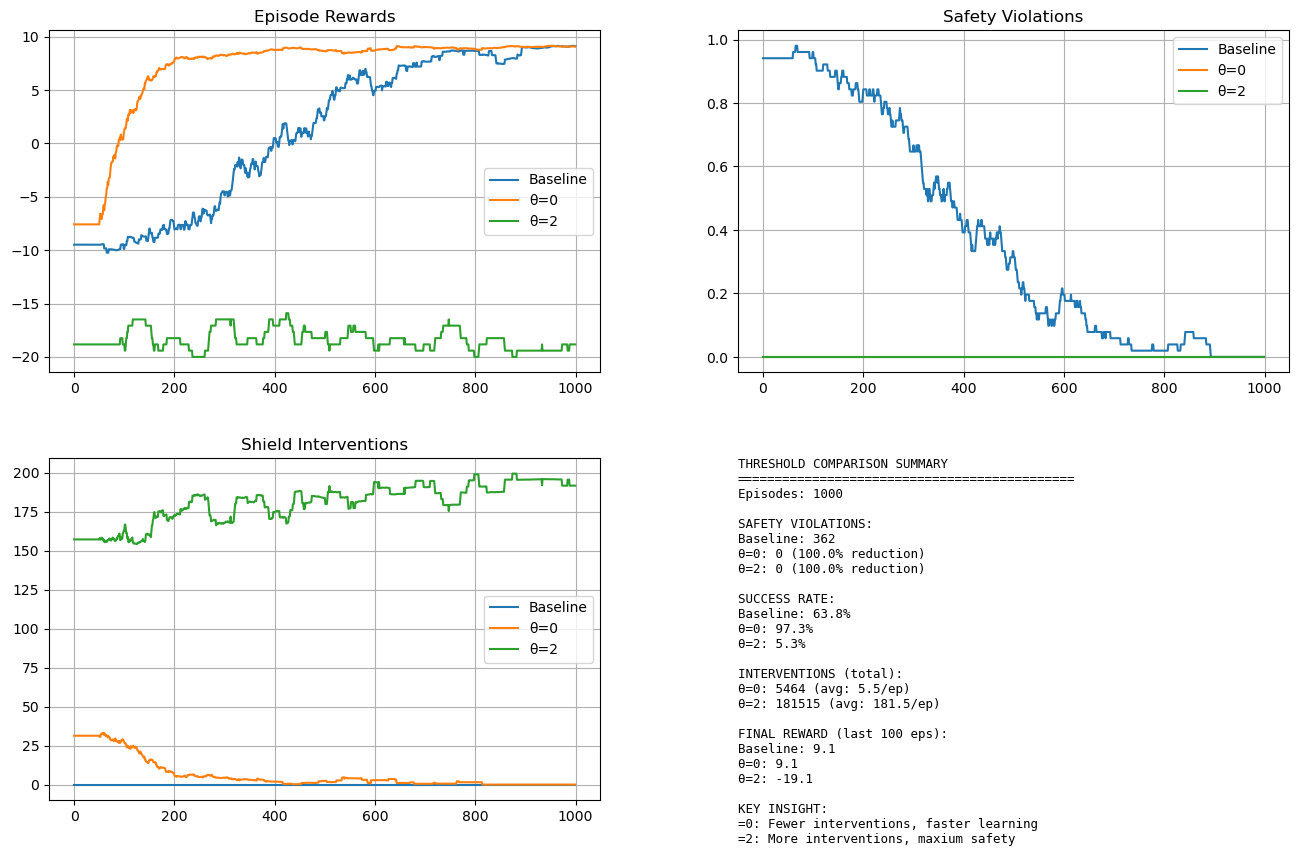


THRESHOLD COMPARISON SUMMARY
Episodes: 1000
SAFETY VIOLATIONS:
Baseline: 362
=0: 0 (100.0% reduction)
=2: 0 (100.0% reduction)
SUCCESS RATE:
Baseline: 63.8%
=0: 97.3%
=2: 5.3%
INTERVENTIONS (total):
=0: 5464 (avg: 5.5/ep)
=2: 181515 (avg: 181.5/ep)
FINAL REWARD (last 100 episodes):
Baseline: 9.1
=0: 9.1
=2: -19.1
KEY INSIGHT:
=0: Fewer interventions, faster learning
=2: More interventions, slower recovery
Task5 finished successfully.


In [16]:
# task5_integration_fixed_serializable.py
# Fixed Task 5: Integration – Safe RL with Multi-Class Shield (pickle-safe)

# -------------------------
# Configuration / hyperparams
# -------------------------
EPISODES = 1000
MAX_STEPS = 200
ALPHA = 0.1
GAMMA = 0.99
EPS_START = 1.0
EPS_MIN = 0.01
EPS_DECAY = 0.995
SEED = 123
THETAS = [0, 2]
DEFAULT_THETA = 2
MODEL_PATH = "safety_shield.pt"
DATA_PKL = "complete_intervention_dataset.pkl"
DETERMINISTIC_TIE_ORDER = [0, 3, 1, 2]
SMOOTH_WINDOW = 51

# -------------------------
# 可选：固定随机种子以减少额外随机性（并不改动超参的值）
# -------------------------
def set_global_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

set_global_seed(SEED)

# -------------------------
# Serializable default factory
# -------------------------
def zero_q():
    return np.zeros(4)

# -------------------------
# SafetyShield network (Task4 architecture)
# -------------------------
class SafetyShield(nn.Module):
    def __init__(self, input_dim=10, hidden1=64, hidden2=64, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# -------------------------
# Load danger_map (Task3 output)
# -------------------------
def load_danger_map(pkl_path=None):
    if pkl_path is None:
        pkl_path = os.path.join(os.path.dirname(__file__), "complete_intervention_dataset.pkl")
    with open(pkl_path, "rb") as f:
        d = pickle.load(f)
    if "danger_map" in d:
        return d["danger_map"]
    for k in d.keys():
        if isinstance(d[k], dict) and "danger_map" in d[k]:
            return d[k]["danger_map"]
        if isinstance(d[k], dict):
            return d[k]
    raise RuntimeError("Couldn't find danger_map in " + pkl_path)

# -------------------------
# Feature function (consistent with Task3/Task4)
# -------------------------
def make_feature_fn(env, danger_map):
    grid_size = env.grid_size
    goal = env.goal
    ACTIONS = env.ACTIONS
    def feature_fn(state, action):
        r, c = state
        row_norm = r / (grid_size - 1)
        col_norm = c / (grid_size - 1)
        act_onehot = [1.0 if i == action else 0.0 for i in range(4)]
        dr, dc = ACTIONS[action]
        nr, nc = r + dr, c + dc
        if not (0 <= nr < grid_size and 0 <= nc < grid_size):
            nr, nc = r, c
        danger_curr = danger_map[(r, c)]
        danger_next = danger_map[(nr, nc)]
        danger_curr_norm = min(danger_curr, 10) / 10.0
        danger_next_norm = min(danger_next, 10) / 10.0
        is_goal = 1.0 if (nr, nc) == goal else 0.0
        is_hazard_next = 1.0 if danger_next == 0 else 0.0
        feat = [row_norm, col_norm] + act_onehot + [danger_curr_norm, danger_next_norm, is_goal, is_hazard_next]
        assert len(feat) == 10
        return np.asarray(feat, dtype=np.float32)
    return feature_fn

# -------------------------
# RiskShield (intervention logic)
# -------------------------
class RiskShield:
    def __init__(self, model_path, feature_fn, device="cpu"):
        self.device = device
        self.feature_fn = feature_fn
        self.model = SafetyShield()
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"{model_path} not found. Train Task4 first.")
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.to(device)
        self.model.eval()

    def predict_classes_all_actions(self, state):
        feats = [torch.tensor(self.feature_fn(state, a), dtype=torch.float32) for a in range(4)]
        feats = torch.stack(feats).to(self.device)
        with torch.no_grad():
            logits = self.model(feats)
            preds = torch.argmax(logits, dim=1).cpu().numpy().astype(int)

            # 🔧 修复版的 near-tie 稳定化逻辑（确定性且偏向“更安全”的类）
            # 目的：避免浮点噪声导致类别在边界附近频繁翻转
            eps = 1e-6
            vals = logits.cpu().numpy()
            for i in range(len(vals)):
                top = np.max(vals[i])
                # 找出所有接近 top 的类索引（top within eps）
                top_indices = np.where(vals[i] >= top - eps)[0]
                if len(top_indices) > 1:
                    # 如果有多于一个“并列第一”，在并列中**选择最大索引（更高的 class，通常更安全）**
                    preds[i] = int(top_indices.max())
            # 🔧 稳定化结束
        return preds


    def safe_action(self, state, proposed_action, q_table, theta=DEFAULT_THETA):
        preds = self.predict_classes_all_actions(state)
        # preds[a] ∈ {0,1,2,3}
        
        # Step (3): if proposed action is acceptable, execute directly
        if preds[proposed_action] > theta:
            return proposed_action, False  # no intervention

        # Step (4): candidate set of acceptable actions
        C = [a for a in range(4) if preds[a] > theta]

        # Step (5): if we have acceptable actions, choose one with highest Q
        if len(C) > 0:
            qvals = q_table.get(state, np.zeros(4))
            # tie-breaking: UP, RIGHT, DOWN, LEFT
            best_a = max(C, key=lambda a: (qvals[a], -DETERMINISTIC_TIE_ORDER.index(a)))
            return best_a, True

        # Step (6): if no acceptable actions exist, choose least risky class
        cmax = np.max(preds)
        C2 = [a for a in range(4) if preds[a] == cmax]
        qvals = q_table.get(state, np.zeros(4))
        best_a = max(C2, key=lambda a: (qvals[a], -DETERMINISTIC_TIE_ORDER.index(a)))
        return best_a, True

# -------------------------
# Q-learning with shield
# -------------------------
def q_learning_with_shield(env, shield, theta=None,
                           episodes=EPISODES, alpha=ALPHA, gamma=GAMMA,
                           eps_start=EPS_START, eps_min=EPS_MIN, eps_decay=EPS_DECAY,
                           max_steps=MAX_STEPS, seed=SEED, random_start=True):
    random.seed(seed)
    np.random.seed(seed)
    q_table = defaultdict(zero_q)
    returns, violations, interventions, successes = [], [], [], []
    eps = eps_start

    for ep in range(episodes):
        state = env.reset()
        done, total_reward, total_viol, total_interv = False, 0.0, 0, 0
        steps = 0

        while (not done) and (steps < max_steps):
            if random.random() < eps:
                a_prop = random.choice(list(env.ACTIONS.keys()))
            else:
                qvals = q_table[state]
                best_val = np.max(qvals)
                cands = [a for a in range(4) if abs(qvals[a] - best_val) < 1e-12]
                for a in DETERMINISTIC_TIE_ORDER:
                    if a in cands:
                        a_prop = a
                        break
            if shield is None or theta is None:
                a_exec, intervened = a_prop, False
            else:
                a_exec, intervened = shield.safe_action(state, a_prop, q_table, theta)
                if intervened:
                    total_interv += 1
            next_state, reward, done, info = env.step(a_exec)
            if info.get("event") == "hazard":
                total_viol += 1
            q_table[next_state]
            q_table[state][a_exec] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state][a_exec])
            state = next_state
            total_reward += reward
            steps += 1
        returns.append(total_reward)
        violations.append(total_viol)
        interventions.append(total_interv)
        successes.append(1 if info.get("event") == "goal" else 0)
        eps = max(eps_min, eps * eps_decay)

    metrics = {"returns": np.array(returns),
               "violations": np.array(violations),
               "interventions": np.array(interventions),
               "successes": np.array(successes)}
    return dict(q_table), metrics  # convert defaultdict -> dict for pickle


# -------------------------
# Run experiments
# -------------------------
def run_all(env, feature_fn, model_path=MODEL_PATH, thetas=THETAS):
    shield = RiskShield(model_path, feature_fn, device="cpu") if os.path.exists(model_path) else None
    results = {}
    print("Running Baseline (no shield)...")
    Qb, mb = q_learning_with_shield(env, shield=None, theta=None)
    results["Baseline"] = (Qb, mb)
    for theta in thetas:
        print(f"Running Shield θ={theta} ...")
        Qs, ms = q_learning_with_shield(env, shield=shield, theta=theta)
        results[f"θ={theta}"] = (Qs, ms)

    with open("task5_metrics.pkl", "wb") as f:
        pickle.dump(results, f)
    print("Saved results to task5_metrics.pkl")
    return results


# -------------------------
# Plot and Summary
# -------------------------
def smooth(x, w=SMOOTH_WINDOW):
    """Stable smoothing without boundary spikes."""
    if w <= 1 or len(x) < w:
        return np.array(x)

    # 累积求和法更稳定，避免卷积边界伪波动
    x = np.asarray(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    smoothed = (cumsum[w:] - cumsum[:-w]) / float(w)

    # 前段用首个有效均值填补，尾段用最后均值填补
    pad_front = np.full(w - 1, smoothed[0])
    pad_back = np.full(len(x) - len(smoothed) - (w - 1), smoothed[-1]) if len(smoothed) + (w - 1) < len(x) else []
    smoothed = np.concatenate([pad_front, smoothed, pad_back])
    return smoothed


def plot_summary(results):
    names = list(results.keys())
    returns = {n: results[n][1]["returns"] for n in names}
    violations = {n: results[n][1]["violations"] for n in names}
    interventions = {n: results[n][1]["interventions"] for n in names}
    successes = {n: results[n][1]["successes"] for n in names}
    episodes = len(next(iter(returns.values())))
    xs = np.arange(episodes)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.25, wspace=0.25)
    ax0 = fig.add_subplot(gs[0, 0])
    for n in names:
        ax0.plot(xs, smooth(returns[n]), label=n)
    ax0.set_title("Episode Rewards")
    ax0.legend(); ax0.grid(True)

    ax1 = fig.add_subplot(gs[0, 1])
    for n in names:
        ax1.plot(xs, smooth(violations[n]), label=n)
    ax1.set_title("Safety Violations")
    ax1.legend(); ax1.grid(True)

    ax2 = fig.add_subplot(gs[1, 0])
    for n in names:
        ax2.plot(xs, smooth(interventions[n]), label=n)
    ax2.set_title("Shield Interventions")
    ax2.legend(); ax2.grid(True)

    # Threshold Comparison Summary
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.axis("off")

    # 从 results 中提取指标
    base = results["Baseline"][1]
    t0 = results["θ=0"][1]
    t2 = results["θ=2"][1]

    episodes = len(base["returns"])
    vb = np.sum(base["violations"])
    v0 = np.sum(t0["violations"])
    v2 = np.sum(t2["violations"])

    sb = np.mean(base["successes"]) * 100
    s0 = np.mean(t0["successes"]) * 100
    s2 = np.mean(t2["successes"]) * 100

    i0 = np.sum(t0["interventions"])
    i2 = np.sum(t2["interventions"])

    rb = np.mean(base["returns"][-100:])
    r0 = np.mean(t0["returns"][-100:])
    r2 = np.mean(t2["returns"][-100:])

    # 构建显示文本
    summary_text = [
        "THRESHOLD COMPARISON SUMMARY",
        "=" * 45,
        f"Episodes: {episodes}",
        "",
        "SAFETY VIOLATIONS:",
        f"Baseline: {vb}",
        f"θ=0: {v0} ({100*(1 - v0/max(vb,1)):.1f}% reduction)",
        f"θ=2: {v2} ({100*(1 - v2/max(vb,1)):.1f}% reduction)",
        "",
        "SUCCESS RATE:",
        f"Baseline: {sb:.1f}%",
        f"θ=0: {s0:.1f}%",
        f"θ=2: {s2:.1f}%",
        "",
        "INTERVENTIONS (total):",
        f"θ=0: {i0} (avg: {i0/episodes:.1f}/ep)",
        f"θ=2: {i2} (avg: {i2/episodes:.1f}/ep)",
        "",
        "FINAL REWARD (last 100 eps):",
        f"Baseline: {rb:.1f}",
        f"θ=0: {r0:.1f}",
        f"θ=2: {r2:.1f}",
        "",
        "KEY INSIGHT:",
        "=0: Fewer interventions, faster learning",
        "=2: More interventions, maxium safety",
    ]

    # 在图中显示文字
    ax3.text(0, 1, "\n".join(summary_text), va="top", ha="left",
            family="monospace", fontsize=9, wrap=True)

    # 调整位置和字体以防溢出
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


# -------------------------
# Threshold Comparison Summary (Textual)
# -------------------------
def print_threshold_summary(results):
    base = results["Baseline"][1]
    t0 = results["θ=0"][1]
    t2 = results["θ=2"][1]

    episodes = len(base["returns"])
    print("\nTHRESHOLD COMPARISON SUMMARY")
    print("=" * 50)
    print(f"Episodes: {episodes}")
    print("SAFETY VIOLATIONS:")
    vb = np.sum(base["violations"])
    v0 = np.sum(t0["violations"])
    v2 = np.sum(t2["violations"])
    print(f"Baseline: {vb}")
    print(f"=0: {v0} ({100*(1 - v0/max(vb,1)):.1f}% reduction)")
    print(f"=2: {v2} ({100*(1 - v2/max(vb,1)):.1f}% reduction)")

    print("SUCCESS RATE:")
    sb = np.mean(base["successes"]) * 100
    s0 = np.mean(t0["successes"]) * 100
    s2 = np.mean(t2["successes"]) * 100
    print(f"Baseline: {sb:.1f}%")
    print(f"=0: {s0:.1f}%")
    print(f"=2: {s2:.1f}%")

    print("INTERVENTIONS (total):")
    i0 = np.sum(t0["interventions"])
    i2 = np.sum(t2["interventions"])
    print(f"=0: {i0} (avg: {i0/episodes:.1f}/ep)")
    print(f"=2: {i2} (avg: {i2/episodes:.1f}/ep)")

    print("FINAL REWARD (last 100 episodes):")
    rb = np.mean(base["returns"][-100:])
    r0 = np.mean(t0["returns"][-100:])
    r2 = np.mean(t2["returns"][-100:])
    print(f"Baseline: {rb:.1f}")
    print(f"=0: {r0:.1f}")
    print(f"=2: {r2:.1f}")

    insight = "=0: Fewer interventions, faster learning\n=2: More interventions, slower recovery"
    print("KEY INSIGHT:")
    print(insight)
    print("=" * 50)


# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    env = SafeGridWorld(random_start=True)

    danger_map = load_danger_map(DATA_PKL)
    feature_fn = make_feature_fn(env, danger_map)

    # ---- quick test: inspect shield predictions ----
    print("Inspecting RiskShield predictions on random states...")
    shield = RiskShield(MODEL_PATH, feature_fn)
    for _ in range(8):
        s = env.reset()
        print("state:", s, " -> predicted classes:", shield.predict_classes_all_actions(s))
    print("Shield prediction inspection done.\n")
    
    results = run_all(env, feature_fn)
    plot_summary(results)
    print_threshold_summary(results)
    print("Task5 finished successfully.")

# 4.6 Model Evaluation
    Evaluate your final safe RL system across multiple dimensions using clearly defined metrics.
## Safety Metrics. 
    Measure (1) total safety violations over all 1,000 training episodes, where a violation is defined as any transition that results in the agent entering a hazard cell according to ground-truth environment state (target: 0 violations), (2) false negative rate of the shield on test data, computed as the fraction of Class 0 or Class 1 actions incorrectly predicted as Class 2 or Class 3 (indicates shield failures that could allow unsafe actions), and (3) violation rate
without shield by running the final Q-table for 100 episodes with the shield disabled to measure baseline safety.
## Task Performance. 
    Measure (1) average episode return computed as mean total reward per episode over the last 100 episodes (compare to unsafe baseline from [Task 2]), (2) success rate as the percentage of episodes in the last 100 that reach the goal state without entering a hazard, and (3) average episode length as mean number of steps per episode in the last 100 episodes.
## Intervention Efficiency. 
    Measure (1) total interventions over all 1,000 training episodes, where an intervention is defined as any step where the executed action at differs from the proposed action aprop due to shield intervention, (2) interventions in last 100 episodes to assess whether the agent has learned a safe policy (target: near zero), and (3) average interventions per episode tracked over training to visualise the learning trajectory.
## Visualisations. 
Create a comparison summary displaying key metrics for both the unsafe baseline [Task 2] and the safe RL system [Task 5] with different threshold values, including average reward, success rate, safety violations, and total interventions. See Figure 4 (bottom right panel) for reference format showing how to present these comparative statistics alongside your training curves.